In [740]:
""" Load Relevant Packages """ 

import sys
sys.path.insert(0,'/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/3. Semester/Python For The Financial Economist')

"""
Python packages
"""

import numpy as np
import seaborn as sns
from scipy import stats, optimize
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
from typing import Union


In [707]:
"""Download data created in Pyhton"""

# create a numpy array
nparray = most_div_port_weights

# Saving the array
np.savetxt("most_div_weights.csv", nparray, delimiter=",")

# Reading the csv into an array
firstarray = np.genfromtxt("most_div_weights.csv", delimiter=",")

In [705]:
"""Download data created in Pyhton"""

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('data_v5.xlsx', engine='xlsxwriter')

# Write dataframe to new sheet
df.to_excel(writer, sheet_name='Sheet2')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [741]:
# Load Data

ret = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/Themes.xlsx')
returns = ret.set_index('Date')

In [742]:
# colors for factors

cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, 13))

# Define inputs for calculations

In [743]:
"""Define inputs"""

# number of periods
num_periods = len(ret)

# number of factors
num_assets = len(returns.columns)

# window size 
window_size =  12 * 5 # 5 years of monthly observations 

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = 60

# time points
time_points = np.arange(1, window_size + 1)

# exponential probabilities for decaying covariance matrix
def calculate_exponential_decay_probabilities(target_time_point: Union[int, float], time_points: np.ndarray,
                                              half_life: Union[float, int]) -> np.ndarray:
    """
    Calculates exponential decay probabilities for an array of time points based on a target time point and a half life.
    Parameters
    ----------
    target_time_point:
        The target time point.
    time points:
        The array of time points to calculate probabilities for.
    half_life:
        The half life of the exponential decay.
    Returns
    -------
    Exponential decay probabilities.
    """
    
    numerator = np.exp(-np.log(2) / half_life * np.clip(target_time_point - time_points, 0, np.inf))
    denominator = np.sum(numerator)

    p_t = numerator / denominator

    return p_t

exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# equally weighted portfolio
w_eq = np.repeat(1.0 / num_assets, num_assets)
weights_eq = np.array(w_eq).astype(float)

# Calculate Risk Contributions for eq_weigths

In [744]:
def calculate_cov_mat(x: np.ndarray, probs: np.ndarray, axis: int = 0) -> np.ndarray:

    """
    Estimates a covariance matrix based on a historical dataset and a set of probabilities.
    Parameters
    ----------
    x:
        The dataset to estimate covariance for.
    probs:
        The probabilities to weight the observations of the dataset by.
    axis:
        The axis to estimate over.
    Returns
    -------
    np.ndarray
        The estimated covariance matrix.
    """

    x = x.T if axis == 1 else x

    expected_x_squared = np.sum(probs[:, None, None] * np.einsum('ji, jk -> jik', x, x), axis=0)
    mu = probs @ x
    mu_squared = np.einsum('j, i -> ji', mu, mu)
    cov_mat = expected_x_squared - mu_squared

    return cov_mat

In [745]:
rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # calculate relative risk constribution 
    rel_risk_contribs[t, :] = rb.calculate_risk_contributions_std(w_eq, cov_mat, scale=True)

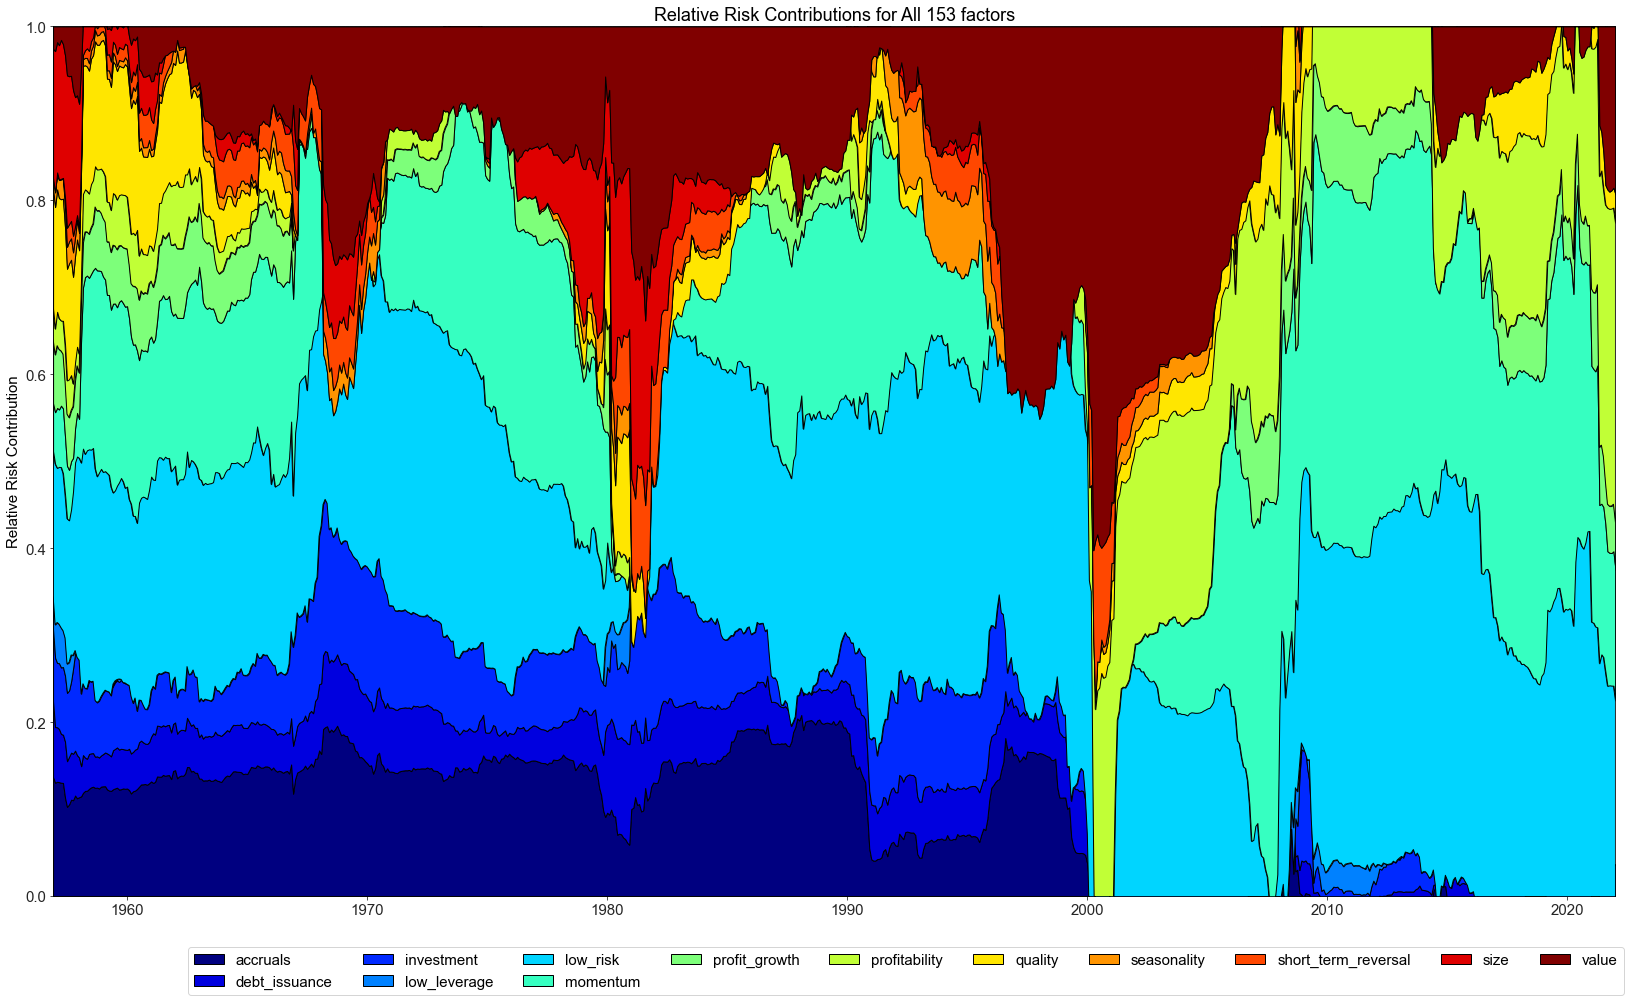

In [746]:
"""
Plot Risk contributions
"""

fig, ax = plt.subplots(figsize=(28, 16))

ax.stackplot(returns.index[window_size:],
              rel_risk_contribs.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Relative Risk Contribution')
ax.set_title("Relative Risk Contributions for All 153 factors");
ax.set_ylim(0,1)
ax.legend(ncol=10, bbox_to_anchor=(1.01, -0.05));

# Calculate Diversification Ratio

In [747]:
"""
Define function for portfolio std and var
"""

def calculate_portfolio_variance(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return weights @ cov_mat @ weights


def calculate_portfolio_std(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return np.sqrt(calculate_portfolio_variance(weights, cov_mat))

In [748]:
"""
Define function to calculate the diversification ratio of Yves Choueifaty and Yves Coignard (2008)
"""

def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    port_std = calculate_portfolio_std(weights=weights, cov_mat=cov_mat)

    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std


In [749]:
cc_ratios = np.zeros(eff_num_periods)
avg_corr = np.zeros(eff_num_periods)

upper_tri_idx = np.triu_indices(num_assets)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # average correlation
    avg_corr[t] = cov_to_corr_matrix(cov_mat)[upper_tri_idx].flatten().mean()
    
    # calculate relative risk constribution 
    cc_ratios[t] = calculate_cc_ratio(w_eq, cov_mat)

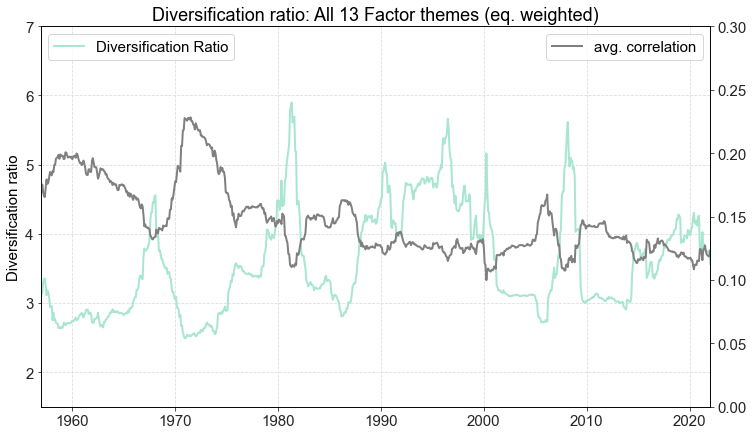

In [750]:
"""
Plot Diversification Ratio and Average Correlation
"""

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(returns.index[window_size:], cc_ratios, label="Diversification Ratio")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratio: All 13 Factor themes (eq. weighted)");
ax.legend(loc='upper left')
ax_new = ax.twinx()
ax.set_ylim(1.5,7)
ax_new.set_ylim(0,0.3)

ax_new.plot(returns.index[window_size:], avg_corr, label="avg. correlation", color="gray")
ax_new.legend(loc='upper right')
ax_new.grid(None)

# Most Diversified Portfolio

In [751]:
"""
Define function for long only portfolio
"""

def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat), init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x

In [752]:
"""
Perform calculations for MDP
"""

most_div_port_weights = np.zeros((eff_num_periods, num_assets))
most_div_port_cc = np.zeros(eff_num_periods)


for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # most diversified
    most_div_port_weights[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc[t] = calculate_cc_ratio(most_div_port_weights[t, :], cov_mat)

# store in data-frame
df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

(0.0, 1.0)

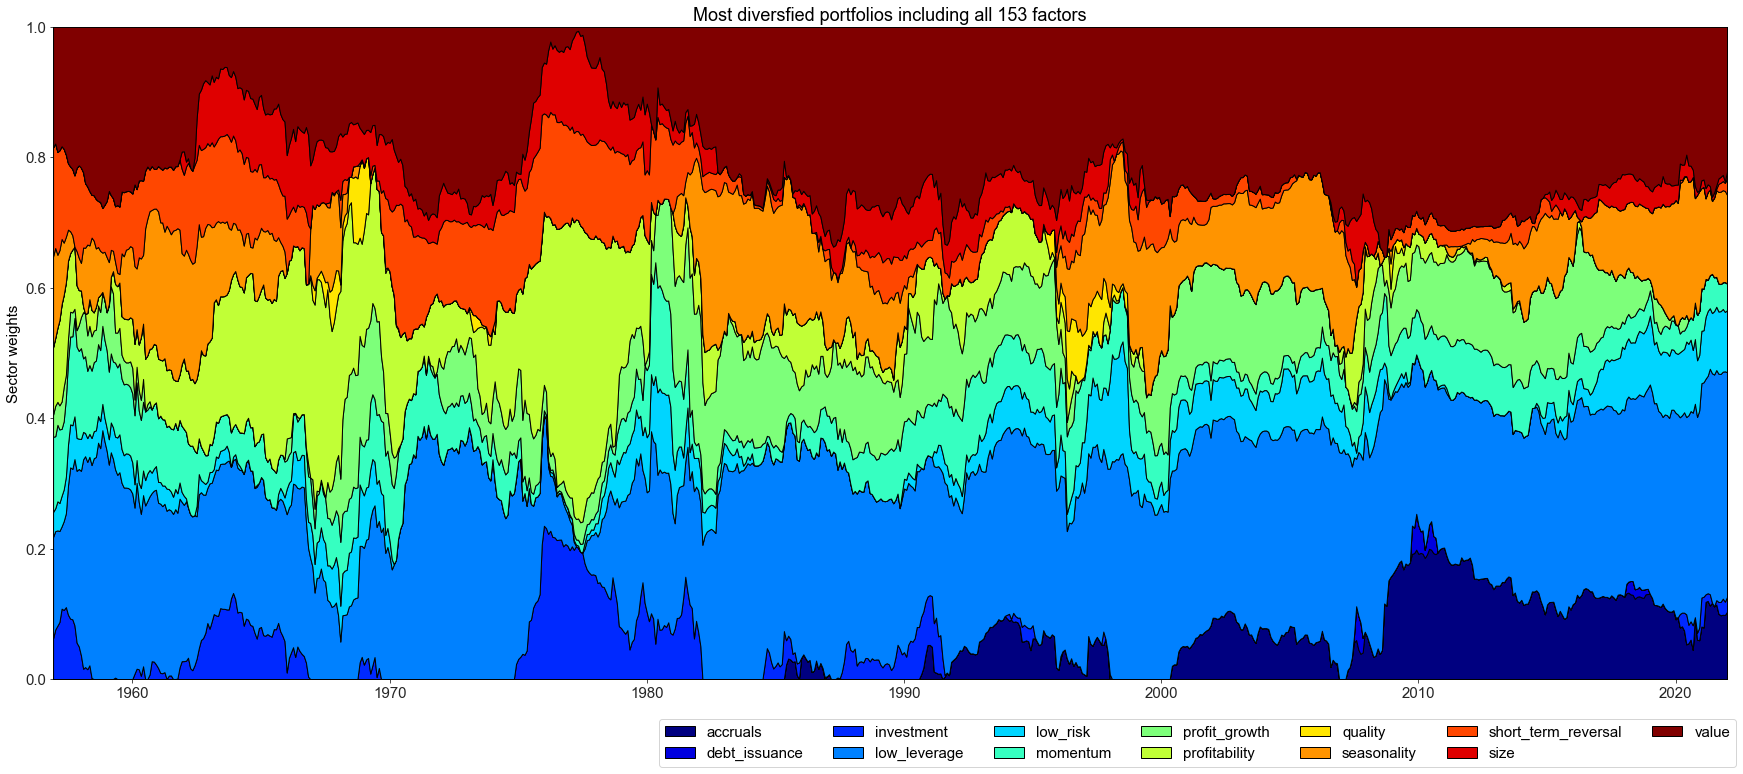

In [753]:
""" 
Plot MDP Weights
"""

fig, ax = plt.subplots(figsize=(30, 12))

ax.stackplot(returns.index[window_size:],
              most_div_port_weights.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Most diversfied portfolios including all 153 factors");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));
ax.set_ylim(0,1)

# Minimum Variance Portfolio

In [754]:
"""
Define function for minimum variance portfolio
"""

def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [755]:
"""
Perform calculations for min_var
"""

min_var_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_port_cc = np.zeros(eff_num_periods)


for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_cov_mat(returns.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # mnimum variance
    min_var_port_weights[t, :] = calculate_min_var_portfolio(cov_mat)
    min_var_port_cc[t] = calculate_cc_ratio(min_var_port_weights[t, :], cov_mat)
    
# store in data-frame
df_min_var_port_weights = pd.DataFrame(data=min_var_port_weights,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

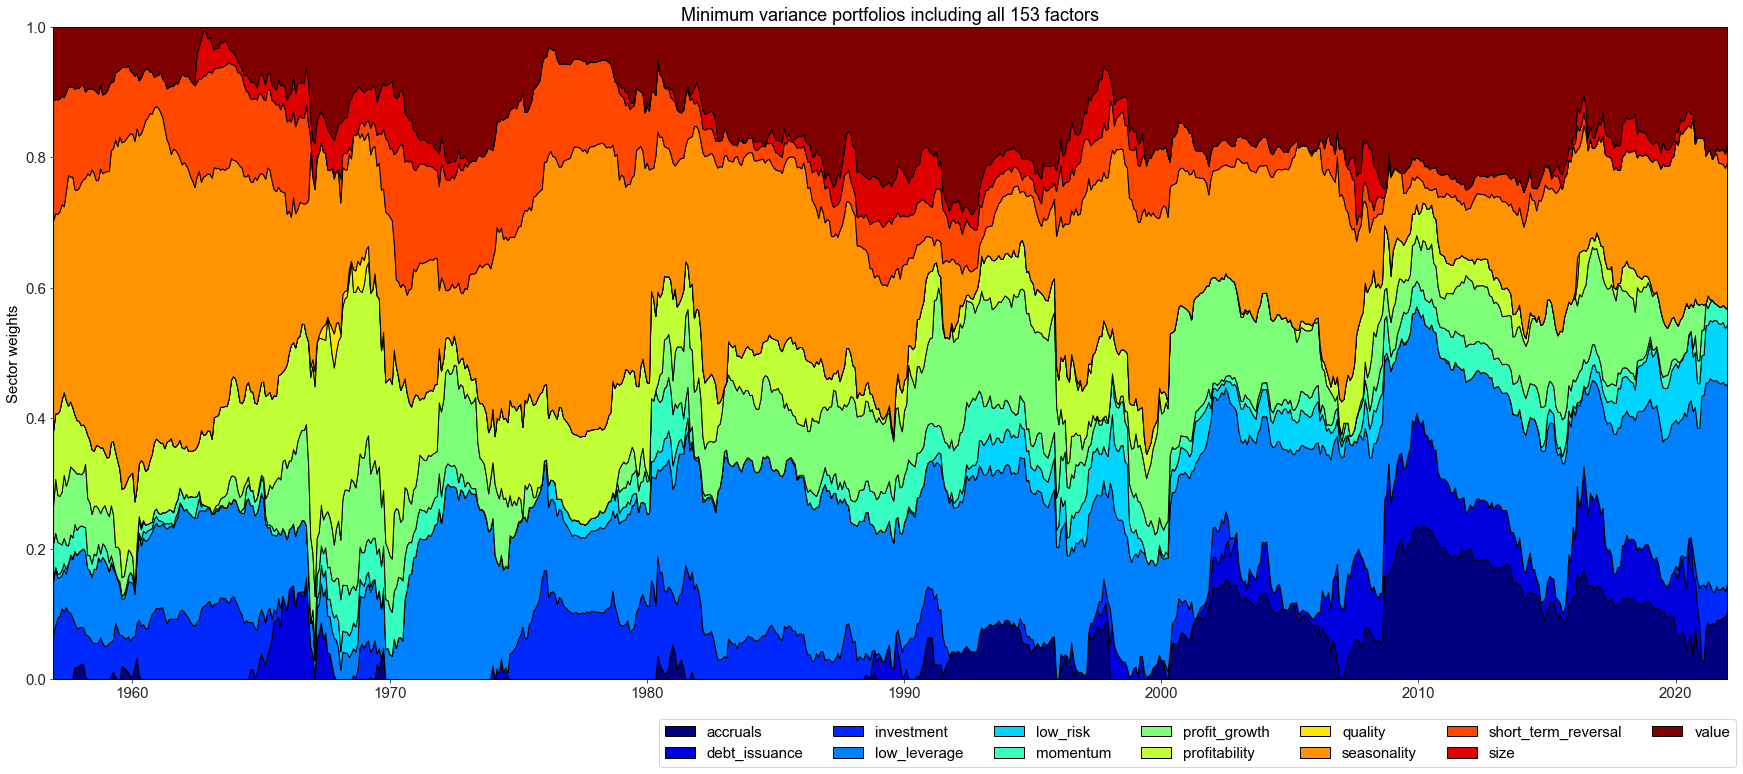

In [756]:
"""
Plot Minimum Variance Weights
"""

fig, ax = plt.subplots(figsize=(30, 12))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Minimum variance portfolios including all 153 factors");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

# Diversifaction Ratio For All Portfolios

In [757]:
ax.plot(returns.index[window_size:], min_var_port_cc, label="DR, minimum variance")


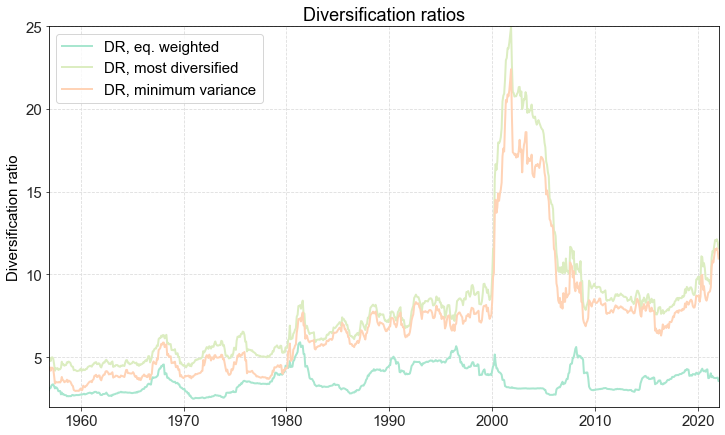

In [762]:
"""
Plotting Diversification Ratios
"""

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(returns.index[window_size:], cc_ratios, label="DR, eq. weighted")
ax.plot(returns.index[window_size:], most_div_port_cc, label="DR, most diversified")
ax.plot(returns.index[window_size:], min_var_port_cc, label="DR, minimum variance")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratios");
ax.set_ylim(2,25)
ax.legend();

# Evaluating Strategies

In [765]:
df_port_ret = pd.DataFrame(index=returns.index[window_size:])

# monthly return
df_port_ret['min-var'] = (returns[window_size:] * df_min_var_port_weights).sum(axis=1)
df_port_ret['most-div'] = (returns[window_size:] * df_most_div_port_weights).sum(axis=1)
df_port_ret['eq-weight'] = (returns[window_size:] @ w_eq)

# total return index
df_port_tri = (1 + df_port_ret).cumprod(axis=0)
df_port_tri[781:]

,min-var,most-div,eq-weight
Date,,,
2021-12-31,3.303988,3.44027,5.089567


(0.0, 6.0)

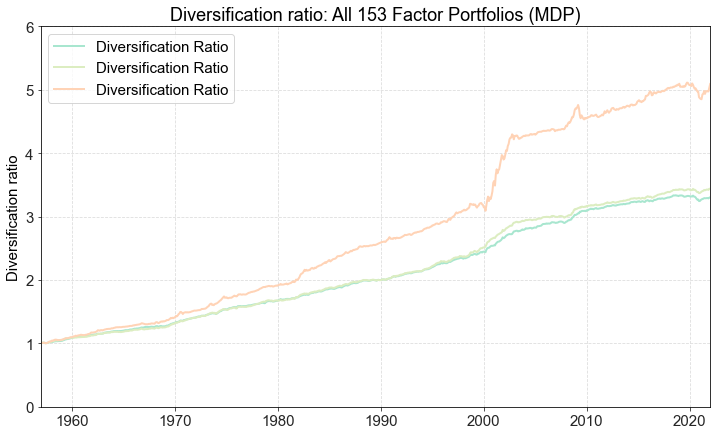

In [766]:
"""
Plot Cummulative Returns 
"""

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(df_port_tri, label="Diversification Ratio")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratio: All 153 Factor Portfolios (MDP)");
ax.legend(loc='upper left')
ax.set_ylim(0,6)

In [767]:
mean_return = df_port_ret.mean(axis=0)
mean_return

min-var      0.001533
most-div     0.001586
eq-weight    0.002099
dtype: float64

In [768]:
std_return = df_port_ret.std(axis=0)
std_return

min-var      0.002747
most-div     0.003011
eq-weight    0.005696
dtype: float64

In [769]:
ir_ratio = mean_return / std_return
ir_ratio

min-var      0.558083
most-div     0.526567
eq-weight    0.368509
dtype: float64